In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json
# %matplotlib qt
R_earth = 6371000

In [2]:

def toRad(angle):
    return angle*np.pi/180

def toDeg(angle):
    return angle*180.0/np.pi

def haversineDist(pt1, pt2):
    ## pt1, pt2 have form (long,lat)
    lat1,lon1 = pt1[1], pt1[0]
    lat2,lon2 = pt2[1], pt2[0]
    lat_delta = toRad(lat2 - lat1)
    lon_delta = toRad(lon2 - lon1)
    
    a = np.sin(lat_delta/2.0)**2 + np.cos(toRad(lat1))*np.cos(toRad(lat2))*np.sin(lon_delta/2.0)*np.sin(lon_delta/2.0)
    c = 2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
    return R_earth*c

def bearingAngle(pt1,pt2):
    ## pt1, pt2 have form (long,lat)
    lat1,lon1 = pt1[1], pt1[0]
    lat2,lon2 = pt2[1], pt2[0]
    y = np.sin(toRad(lon2 - lon1))*np.cos(toRad(lat2))
    x = np.cos(toRad(lat1))*np.sin(toRad(lat2)) - np.sin(toRad(lat1))*np.cos(toRad(lat2))*np.cos(toRad(lon2 - lon1))
    
    bearing = toDeg(np.arctan2(y,x))
    bearing = np.fmod(bearing+360,360)
    return bearing

def areEqual(pt1,pt2):
    ## pt1, pt2 have form (long,lat)
    dist = haversineDist(pt1,pt2)
    if dist<1.0:
        return True
    return False

def getNearestNode(start_pt,nodes_list):
    nearest_node_id = -1
    min_dist = 1000000000;
    # find the nearest node
    for node in nodes_list:
        node_id = node['id']    
        pt = node['loc']
        dist_to_node = haversineDist(start_pt, pt)
        if dist_to_node<min_dist:
            nearest_node_id = node_id
            min_dist = dist_to_node
    return nearest_node_id

def getNearestPath(start_pt,nodes_list,paths_list):
    
    nearest_node_id = getNearestNode(start_pt,nodes_list)      
    
    #find the nearest link and path
    links_list = nodes[nearest_node_id]['links']
#     print("links list: ",links_list)
    
    min_dist = np.inf
    link_id = None
    path_id = None
    min_dist_pt = None
    for path in paths_list:
        #print("Path from link id",path['from_link_id'])
        if path['from_link_id'][0] in links_list:        
            center_pts = path['center']        
            for pt in center_pts:
                dist_to_pt = haversineDist(start_pt,pt)
                if dist_to_pt<min_dist:
                    min_dist = dist_to_pt
                    path_id = path['path_id']
                    min_dist_pt = pt
                    link_id = path['from_link_id']
                    #print("lnk_id:",link_id," path_id: ",path_id," min_dis: ",min_dist)
    return [min_dist_pt, path_id,link_id,nearest_node_id,min_dist]

def getNearestPathExcludePath(start_pt,nodes_list,paths_list,excluded_paths):
    
    nearest_node_id = getNearestNode(start_pt,nodes_list)      
    
    #find the nearest link and path
    links_list = nodes[nearest_node_id]['links']
#     print("links list: ",links_list)
    min_dist = np.inf
    link_id = None
    path_id = None
    min_dist_pt = None
    for path in paths_list:
        if path['path_id'] not in excluded_paths:
            if path['from_link_id'][0] in links_list:        
                center_pts = path['center']        
                for pt in center_pts:
                    dist_to_pt = haversineDist(start_pt,pt)
                    if dist_to_pt<min_dist:
                        min_dist = dist_to_pt
                        path_id = path['path_id']
                        min_dist_pt = pt
                        link_id = path['from_link_id']
                        #print("lnk_id:",link_id," path_id: ",path_id," min_dis: ",min_dist)
    return [min_dist_pt, path_id,link_id,nearest_node_id,min_dist]


def getNearestPath2(start_pt,paths_list):    
    min_dist = np.inf
    link_id = None
    path_id = None
    min_dist_pt = None
    for path in paths_list:               
        center_pts = path['center']        
        for pt in center_pts:
            dist_to_pt = haversineDist(start_pt,pt)
            #print(" path_id: ",path['path_id']," min_dis: ",dist_to_pt)
            if dist_to_pt<min_dist:
                min_dist = dist_to_pt
                path_id = path['path_id']
                min_dist_pt = pt
                link_id = path['from_link_id']
                #print("lnk_id:",link_id," path_id: ",path_id," min_dis: ",min_dist)
    return [min_dist_pt, path_id, link_id, [], min_dist]

def get_coord(pt_id,paths_list):
    start_pt = None
    for path in paths_list:
        if path['path_id']==pt_id:
            start_pt = path['center'][0]# path['start']
            break
    return start_pt

def expand_path(cur_state, paths_list):
    expaned = None
    for path in paths_list:
        if path['path_id'] == cur_state:
            expanded = path['connected_to']
            break
    return expanded

In [3]:
import math
import queue as Q

def get_cost(pt1, pt2):
    ''' calculates the distance between
        the two input states/coordinates 
    '''
    cost = haversineDist(pt1,pt2)
    return cost

def shortest_path(start,goal,paths):
    print("shortest path called")
    # variable to collect the path
    short_path =[]
    
    # calculate the heuristic distance(h) between the start and the goal
    # for initialization of the frontier. path cost(g) = 0
    start_pt = get_coord(start, paths)
    goal_pt = get_coord(goal, paths)
    
    print("start, goal:",start_pt, goal_pt)
    init_cost = get_cost(start_pt, goal_pt) 
    
    # states with estimated costs. Tuple is used in the queue
    frontiers = Q.PriorityQueue()    
    frontiers.put((init_cost, start))
    
    # parent_tree keeps track of how the paths are expanded based on which
    # minimum cost path is connected
    parent_tree = {}
    parent_tree[start] = 0 
    
    # temporary storage of expanded paths from parent/current state
    next_states = []
 
    # collects the path costs
    path_costs = {}
    path_costs[start] = 0  #start with 0 path coast for the starting point
        
    #goal_found = (start == goal)   
    
    # iterate until all frontiers are checked. If the goal is reached before all
    # the frontiers are examined, the loop stops.
    
    while not frontiers.empty():       
        # get the current state.
        #   --> the first value of the tuple is the estimated distance and 
        #   --> the second value is the state
        state_val = frontiers.get()
        curr_state = state_val[1] 

        if curr_state == goal:
            #goal_found = True
            print('goal found')
            break
        
        # expand the path
        next_states =  expand_path(curr_state, paths) #M.roads[curr_state] 
        #print("next states: ",next_states)
        #         if len(next_states)==1 and next_states[0]<0 and not (curr_state == goal):
        #             print("Can't expand. Reached dead-end")
            #return []
        for next_state in next_states: 
            # if next_state is not a member of next_states, it's already explored.
            # I don't need to save the explored states.
            if next_state >0:
                # prepare the states to calculate cost
                curr_intersec = get_coord(curr_state,paths) #M.intersections[curr_state]
                next_intersec = get_coord(next_state,paths) #M.intersections[next_state]
                goal_intersec = get_coord(goal, paths) #M.intersections[goal] 

                # compute the path cost
                g = get_cost(curr_intersec, next_intersec) + path_costs[curr_state]            
                if next_state not in path_costs or g < path_costs[next_state]:

                    # calculate the estimated path cost (heuristic function: euclidean distance)
                    h = get_cost(next_intersec, goal_intersec)

                    # total estimated cost
                    f = g + h

                    # put the next state in frontiers dictionary
                    frontiers.put((f, next_state))

                    # add/update the g_costs dictionary
                    path_costs[next_state] = g
                    parent_tree[next_state] = curr_state
    
    # At this point the goal is assumed to be reached. So, construct the path information 
    # using the parent_tree dictionary starting from the goal point to the starting point.
    
    #     print("parent tree: len->",len(parent_tree)," list: ",parent_tree)
    if curr_state != goal:
        print("\n Unable to reach goal")
    else:
        curr_state = goal
        while curr_state != start:
            # inserts the current point at the top of the list
            short_path.insert(0, curr_state) 
            curr_state = parent_tree[curr_state]
        short_path.insert(0, start)  
    
    return short_path
 
def toRef(origin_ref, lane_bound):
    boundary_transformed_x = []
    boundary_transformed_y = []
    for pt in lane_bound:
        ang = 90-bearingAngle(origin_ref, pt)
        dist = haversineDist(origin_ref, pt)
        x = dist*np.cos(toRad(ang))
        y = dist*np.sin(toRad(ang))
        boundary_transformed_x.append(x)
        boundary_transformed_y.append(y)
    return [boundary_transformed_x, boundary_transformed_y]

In [4]:
##### Load all the relevant data
#Read nodes.json file
with open('nodes.json','r') as nodes_file:
    nodes_data = nodes_file.read()
    
nodes_obj = json.loads(nodes_data)

####### load the links.json file
# with open('links.json','r') as links_file:
#     links_data = links_file.read()
    
# links_obj = json.loads(links_data)

####### load the paths.json file
with open('lanes.json','r') as lanes_file:
    lanes_data = lanes_file.read()
    
lanes_obj = json.loads(lanes_data)
###### 
nodes = nodes_obj['nodes']
# links = links_obj['links']
lanes = lanes_obj['lanes']

In [15]:
### Test the start point of the car and the destination address

car_pt = [-83.696883,42.300927 ]#[-83.698930,42.300403]
#[-83.699068,42.301368 ]#[-83.697641,42.301652]#[-83.697905,42.300125]#[-83.698307,42.300337]
         #[-83.698229,42.301361] 
           #[-83.697455,42.300010]#[-83.697471, 42.299885] 

dest_pt =      [-83.698311,42.301009 ]       
       

#[car_start, path_id1, _, _,dist1] = getNearestPath(car_pt,nodes,paths)
[car_start, path_id1, _, _,dist1] = getNearestPath(car_pt,nodes,lanes)
[car_stop, path_id2, _, _,dist2] = getNearestPath(dest_pt,nodes,lanes)
print("start: ",path_id1," pt:(",car_start,"),  start distance to link: {:0.4f} m".format(dist1))
print("goal: ",path_id2, " pt:(",car_stop,"),  stop distance to link: {:0.4f} m".format(dist2,))


a_star_path = shortest_path(path_id1,path_id2,lanes)
if len(a_star_path)==0:
    print("2nd attempt to get to the destination ...")
    exclude_path=[path_id2]    
    [car_stop, path_id22, _, _,dist2] = getNearestPathExcludePath(dest_pt,nodes,lanes,exclude_path)
    a_star_path = shortest_path(path_id1,path_id22,lanes)
    print("goal: ",path_id2, " pt:(",car_stop,"),  stop distance to link: {:0.4f} m".format(dist2,))
print("path IDs to get to the destination): ",a_star_path)

start:  124  pt:( [-83.69689330458641, 42.300925571809515] ),  start distance to link: 0.8622 m
goal:  167  pt:( [-83.6982997879386, 42.30098384637841] ),  stop distance to link: 2.9450 m
shortest path called
start, goal: [-83.69696907699107, 42.300876968298034] [-83.69810063391924, 42.30098012672668]
goal found
path IDs to get to the destination):  [124, 125, 114, 127, 131, 167]


In [16]:
# Construct the path to get to the destination
final_path_wp = []
if len(a_star_path)>0:
    start_path_id = a_star_path[0]
    end_path_id = a_star_path[-1]
    #print("start, end",start_path_id, ", ",end_path_id)

    center_pts = []
    #Get points from the first segment
    for path in lanes:
        if path['path_id'] == start_path_id:
            center_pts = path['center']
            break

    found = False
    for pt in center_pts:
        if pt[0]==car_start[0] and pt[1]==car_start[1]:
            found = True
        if found:
            final_path_wp.append(pt)

    ## get points from other road segments
    for i in range(1,len(a_star_path)-1):
        path_id = a_star_path[i]
        for path in lanes:
            if path['path_id'] == path_id:
                center_pts = path['center']
                for pt in center_pts:
                    final_path_wp.append(pt)

    ## get the points from the last segment upto the destination point
    center_pts = []
    for path in lanes:
        if path['path_id'] == end_path_id:
            center_pts = path['center']
            break        
    found = True

    for pt in center_pts:
        if pt[0]==car_stop[0] and pt[1]==car_stop[1]:
            found = False
            final_path_wp.append(pt)
        if found:
            final_path_wp.append(pt)
else:
    print("No path found to route the vehicle.")
### At this point all the points are collected
print("final pts : ",len(final_path_wp))


final pts :  45


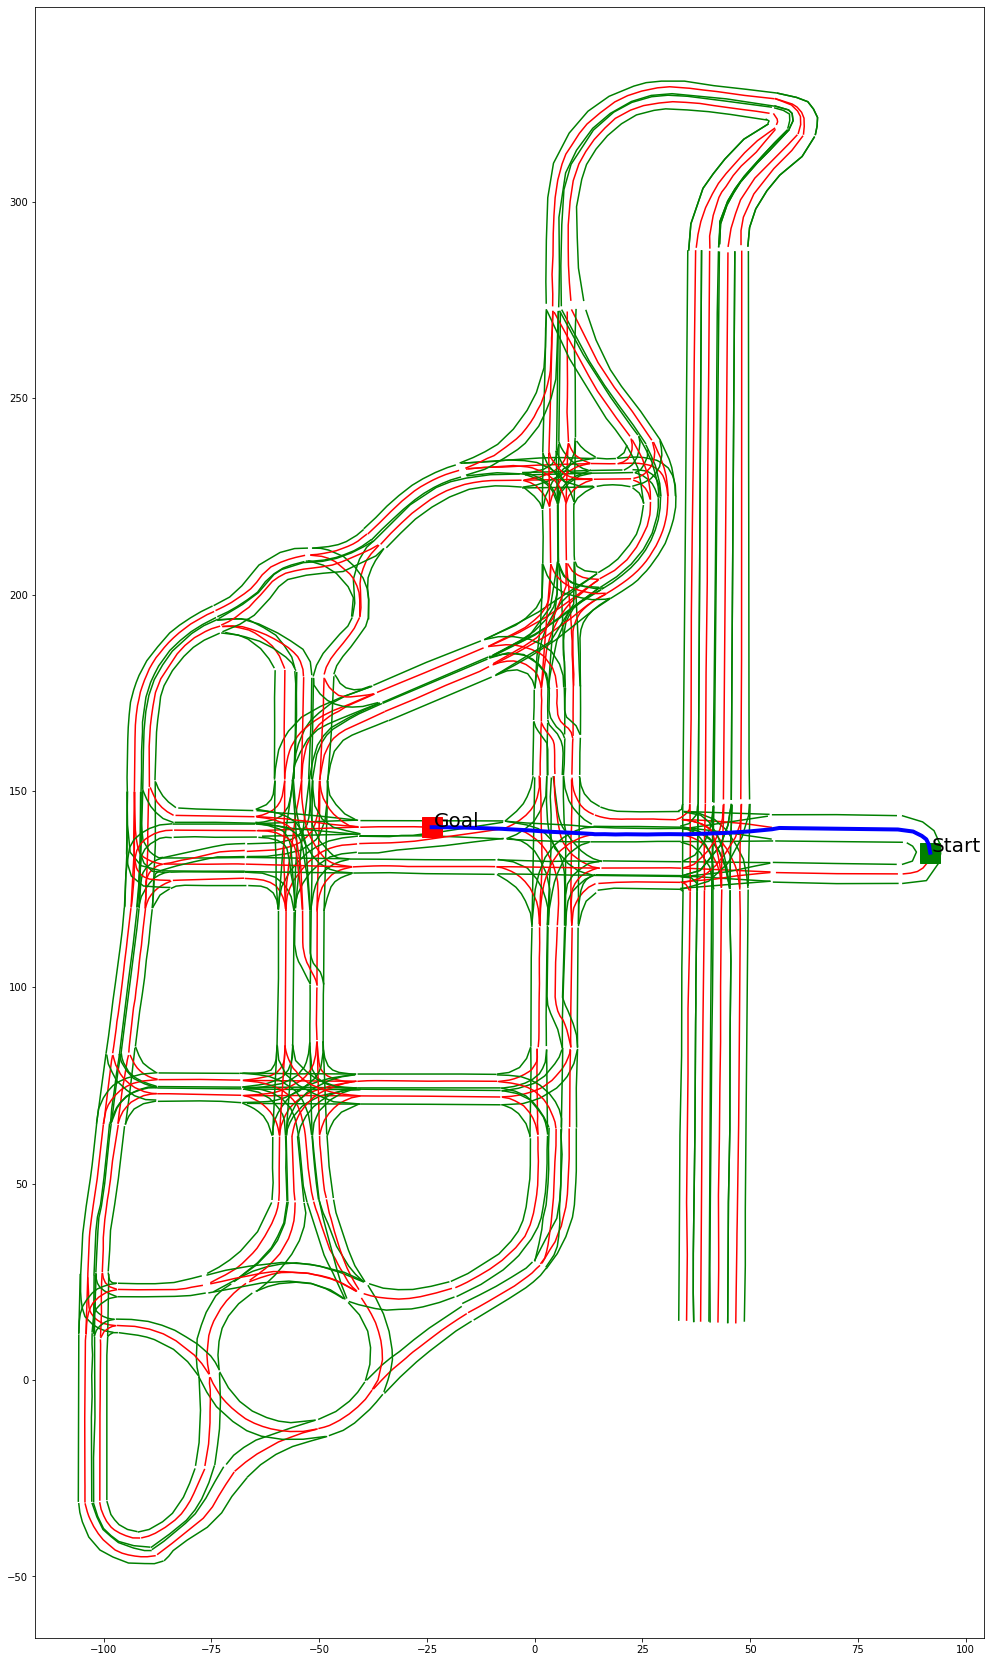

In [17]:
origin = [-83.698009, 42.299718]

plt.figure(figsize=(17,30))
# plt.title("Road Map")
# #plt.grid()
# x_max = 436.86440171995844
# y_max = 316.3495663038422
# plt.xlim([0.0,x_max])
# plt.ylim([0.0,y_max])
# back_img = plt.imread("geojson_map.PNG") # ("google_map.PNG")# 
# plt.imshow(back_img,extent=[0,x_max,0,y_max+2.0],alpha = 0.2)
for path in lanes:
    left_bound = toRef(origin,path['left_boundary']['boundary'])
    
    if path['left_boundary']['type'] =="yellow":
        left_color = 'g'
    else:
        left_color = 'g'
        
    right_bound = toRef(origin, path['right_boundary']['boundary'])
    if path['right_boundary']['type'] =="yellow":
        right_color = 'g'
    else:
        right_color = 'g'
    
    center = toRef(origin,path['center'])    
    plt.plot(left_bound[0],left_bound[1],left_color)
    plt.plot(right_bound[0],right_bound[1],right_color)
    plt.plot(center[0],center[1],'r')    
    
#plot the calculated path from start to destination
if len(final_path_wp)>0:
    computed_path = toRef(origin,final_path_wp)
    starting_pt = toRef(origin, [car_start])
    stoping_pt = toRef(origin, [car_stop])
    plt.plot(starting_pt[0],starting_pt[1],'gs',ms=20)
    plt.text(starting_pt[0][0]+0.4,starting_pt[1][0]+0.2,'Start', fontsize=20)# bbox=dict(facecolor='green', alpha=0.5)) 
    plt.plot(stoping_pt[0],stoping_pt[1],'rs',ms=20)
    plt.text(stoping_pt[0][0]+0.4,stoping_pt[1][0]+0.2,'Goal', fontsize=20)# bbox=dict(facecolor='red', alpha=0.5))
    plt.plot(computed_path[0],computed_path[1],'b',linewidth=4.0)   
plt.show()
    
# [36.076445, -79.768651],[36.073600, -79.768651]
# [36.076445, -79.773512],[36.073600, -79.773512]

# print("horizontal dim: ",haversineDist([36.076445, -79.768651],[36.073600, -79.768651])) 
# print("vertical dim: ",haversineDist([36.076445, -79.768651],[36.076445, -79.773512]))


In [8]:

# start = [36.074648, -79.772065] #[36.073889, -79.769244] #start pt
# [min_dist_pt, path_id, link_id, node_id] = getNearestPath(start,nodes,paths)
# if path_id is not None:
#     #print("Nearest path found.")
#     print("Nearest Point on the road: ",min_dist_pt)
#     #print("--> distance between pt and nearest road pt {:0.4f} m".format(min_dist))
#     print("--> Path id: ", path_id)
#     print("--> Link id: ", link_id)
    
#     print("")      
    
#     #print(get_coord(11046,paths)) #36.075016, -79.769170